In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sympy.utilities.iterables import multiset_permutations
import statistics as st
import math

GMM Parameters

In [11]:
K = 1
D = 10
N_max = 9 # Maximum datapoints in a simulation
max_iters = 10

In [12]:
ret = {}

for nn in range(1,N_max):
  point_cnt = [nn for _ in range(K)] # No of points in each cluster
  N = sum(point_cnt)
  ret[N] = {}
  for iter in tqdm(range(max_iters)):
      ret[N][iter] = {}
      
      # GMM means, data and T is sampled uniformly randomly
      mu = np.random.rand(K,D)
      X = np.zeros((N, D))
      T  = np.random.rand(D,D)
      
      st_pt = 0
      for i, pt_cnt in enumerate(point_cnt):
          en_pt = st_pt+pt_cnt
          X[st_pt:en_pt] = np.random.normal(mu[i], size=(pt_cnt, D))
          st_pt = en_pt

      y = np.matmul(X, T)
      
      ret[N][iter]["GT"] = {}
      ret[N][iter]["GT"]["mu"] = mu
      ret[N][iter]["GT"]["X"] = X
      ret[N][iter]["GT"]["y"] = y
      ret[N][iter]["GT"]["T"] = T

      mu_hat = np.zeros_like(mu)
      eta_hat = np.zeros_like(mu)
      st_pt = 0
      for i, pt_cnt in enumerate(point_cnt):
          en_pt = st_pt+pt_cnt
          mu_hat[i] = np.mean(X[st_pt:en_pt],axis=0)
          eta_hat[i] = np.mean(y[st_pt:en_pt],axis=0)
          st_pt = en_pt

      ans_GMM = np.matmul(np.linalg.pinv(mu_hat), eta_hat)
      gtperm = [i for i in range(len(y))]

      ret[N][iter]["EST"] = {}
      ret[N][iter]["EST"]["mu_hat"] = mu_hat
      ret[N][iter]["EST"]["eta_hat"] = eta_hat
      ret[N][iter]["EST"]["ans_GMM"] = ans_GMM

      ret[N][iter]["CANDIDATES"] = []

      for perm in list(multiset_permutations(range(len(y)))):
          ans = np.matmul(np.linalg.pinv(X), np.array(y[perm]))
          XT_Yperm = np.linalg.norm(np.matmul(X, ans) - y[perm])
          perm_dist = np.count_nonzero(np.subtract(perm, gtperm))
          del_T = round(np.linalg.norm(ans - T), 2)
          del_T_GMM = round(np.linalg.norm(ans - ans_GMM), 2)

          if XT_Yperm < 1e-9:
              tmp = {}
              tmp["del_T"] = del_T
              tmp["del_T_GMM"] = del_T_GMM
              tmp["XT_Yperm"] = XT_Yperm
              tmp["perm"] = perm
              tmp["perm_dist"] = perm_dist
              ret[N][iter]["CANDIDATES"].append(tmp)

100%|██████████| 10/10 [01:06<00:00,  6.60s/it]


In [13]:
from collections import defaultdict

def get_plot(idx,N):
    l = ret[N][idx]["CANDIDATES"]
    dels =[(l[i]['del_T_GMM'], -1*l[i]['del_T']) for i in range(len(l))]
    sorted_dels = sorted(dels)
    x, y = list(zip(*sorted_dels))
    y = [-1*ele for ele in y]
    plt.plot(x, y, 'k-')
    plt.show()

# def get_plot(idx):
    # l = ret[N][idx]["CANDIDATES"]

    # [(val['del_T_GMM'],i) for i,val in enumerate(ret[N][idx]["CANDIDATES"])]
def accum_prob_plot(N, N_max):
    occ_cnts = defaultdict(int)
    sum_del_GMM = defaultdict(int)
    sum_del_T = defaultdict(int)
    cnt_GMM = defaultdict(int)

    for idx in range(max_iters):
        l = ret[N][idx]["CANDIDATES"]
        dels =[(l[i]['del_T_GMM'], -1*l[i]['del_T']) for i in range(len(l))]
        sorted_dels = sorted(dels)
        del_GMM, del_T = list(zip(*sorted_dels))
        del_T = [-1*ele for ele in del_T]

        min_del_T = min(del_T)
        del_T_idx = del_T.index(min_del_T)
        occ_cnts[del_T_idx] += 1
            
        for i_gmm in range(len(del_GMM)):
            sum_del_GMM[i_gmm] += del_GMM[i_gmm]
            sum_del_T[i_gmm] += del_T[i_gmm]
            cnt_GMM[i_gmm] += 1

    l = [(k,sum_del_GMM[k]/cnt_GMM[k], sum_del_T[k]/cnt_GMM[k]) for k,_ in sum_del_GMM.items()]
    l.sort()
    idx_del_GMM, avg_del_GMM, avg_del_T = list(zip(*l))
    # plt.plot(idx_del_GMM, avg_del_T)#, "del T")
    
    # for i, j in zip(idx_del_GMM[:3], avg_del_T[:3]):
    #    plt.text(i, j, '({}, {})'.format(i, j))
    # plt.show()

    l = [(k,v/max_iters) for k,v in occ_cnts.items()]
    l.sort()
    x,probs = list(zip(*l))    
    # plt.plot(x, probs)

    # for i, j in zip(x[:3], probs[:3]):
    #    plt.text(i, j, '({}, {})'.format(i, j))
    # plt.show()

    second_closest_avg = []
    N_list = list(range(1,N_max))
    
    nrows = 3
    ncols = math.ceil(N_max/3.0)
    fig, axs = plt.subplots(nrows, ncols)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    # for ax in axs.flat:
    #     ax.set(xlabel='Normalized_dist from T')

    for nn in N_list:
      second_closest = []
      # for idx in range(max_iters):
      for idx in range(max_iters):
        l = ret[nn][idx]["CANDIDATES"]
        T_2 = round(np.linalg.norm(ret[nn][idx]["GT"]["T"]), 2)
        # dels =[l[i]['del_T']/T_2 for i in range(len(l)) if l[i]['del_T'] >= 1e-9]
        dels =[l[i]['del_T'] for i in range(len(l)) if l[i]['del_T'] >= 1e-9]
        # dists_dels =[l[i]['del_T']/T_2 for i in range(len(l)) if l[i]['del_T']]
        dists_dels =[l[i]['del_T'] for i in range(len(l)) if l[i]['del_T']]
        
        plt.hist(dists_dels)


        axs[int(nn/ncols),nn%ncols].hist(dists_dels)
        axs[int(nn/ncols),nn%ncols].set_title('N= '+str(nn))
        if len(dels) == 0:
          second_closest.append(0)
        else:
          second_closest.append(min(dels))
        # print(nn,dels[:min(len(dels),10)])
      second_closest_avg.append(st.mean(second_closest))
    
    # for ax in axs.flat:
    #     ax.label_outer()

    plt.show()

    plt.plot(N_list, second_closest_avg) 
    plt.xlabel("N")
    plt.ylabel("Second closest delta_T")
    for i, j in zip(N_list, second_closest_avg):
       plt.text(i, j, '({}, {})'.format(i, round(j,4)))
    plt.show()
    return second_closest_avg

        # sorted_dels = sorted(dels)
        # del_GMM, del_T = list(zip(*sorted_dels))
        # del_T = [-1*ele for ele in del_T]

        # min_del_T = min(del_T)
        # del_T_idx = del_T.index(min_del_T)
        # occ_cnts[del_T_idx] += 1
            
        # for i_gmm in range(len(del_GMM)):
        #     sum_del_GMM[i_gmm] += del_GMM[i_gmm]
        #     sum_del_T[i_gmm] += del_T[i_gmm]
        #     cnt_GMM[i_gmm] += 1

    
    

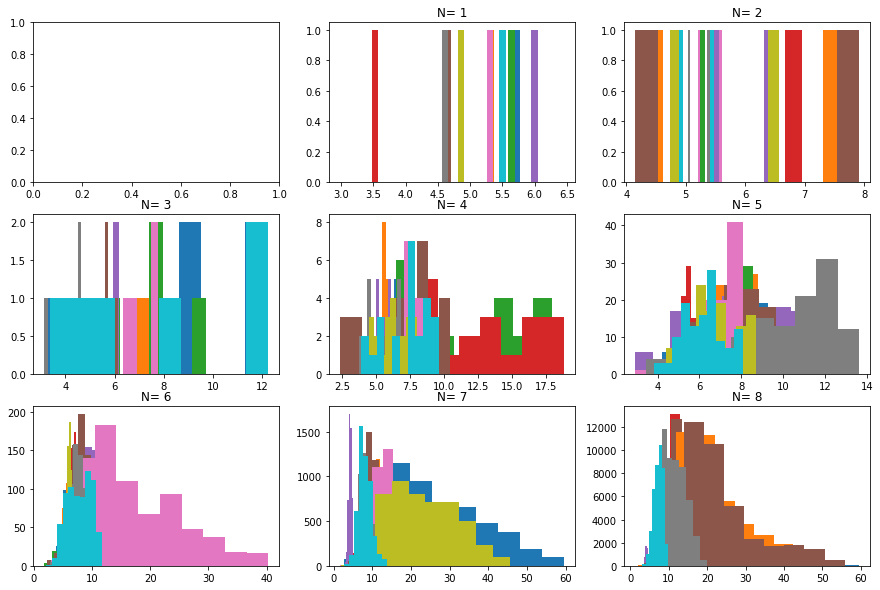

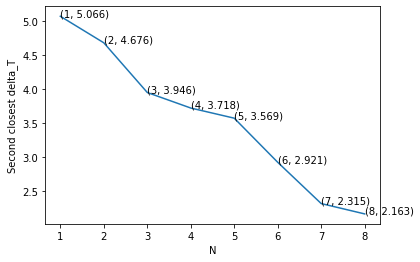

In [14]:
N = 7
# get_plot(8,N)
second_closest_avg = accum_prob_plot(N, N_max)

Rough

In [ ]:
import numpy as np
from itertools import permutations
num_means = 5
dim = 10
M = np.random.randn(dim, num_means)
A = np.random.randn(dim, dim)
M2 = A @ M
I = np.eye(num_means)
for inds in permutations(np.arange(num_means)):
    P = I[np.array(inds)]
    dist = np.linalg.norm(M2 @ (P-I) @ np.linalg.pinv(M))
    if dist / np.linalg.norm(A) < 1:
        print(dist, dist / np.linalg.norm(A), inds)

0.0 0.0 (0, 1, 2, 3, 4)
7.002539602003183 0.7631027619550541 (0, 1, 2, 4, 3)
6.2353999058430905 0.6795036030473826 (0, 1, 3, 2, 4)
6.582024397506803 0.7172770569631846 (0, 3, 2, 1, 4)
8.526493567456829 0.9291758648900749 (0, 3, 2, 4, 1)
8.474549172147878 0.923515216927869 (0, 4, 2, 1, 3)
7.222220585113506 0.7870425287380272 (0, 4, 2, 3, 1)
8.898739344729941 0.9697414020963134 (3, 1, 2, 0, 4)
8.472403684678547 0.9232814121218071 (3, 1, 2, 4, 0)


In [ ]:
gtperm = [i for i in range(len(y))]
for perm in list(multiset_permutations(range(len(y)))):
    ans = np.matmul(np.linalg.pinv(X), np.array(y[perm]))
    XT_Yperm = np.linalg.norm(np.matmul(X, ans) - y[perm])
    perm_dist = np.count_nonzero(np.subtract(perm, gtperm))
    if XT_Yperm < 1e-9 and perm_dist != 0:
        print("XT_Yperm", XT_Yperm)
        # print("Del T:" , round(np.linalg.norm(ans - T), 2))
        print("Perm distance:", perm_dist)
        print("-----")
        print("perm: ", perm)
        print("-----")
        print("ans: ", np.array(ans))
        print("-----")
          print("yperm: ", np.array(y[perm]))
        print("===================\n")

IndentationError: ignored